In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests

In [3]:
import pandas as pd

In [4]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [5]:
df_train.head()

id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...

In [6]:
df_train.isnull().sum() 
df_train.dropna(inplace=True)  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='caption_length', ylabel='Count'>

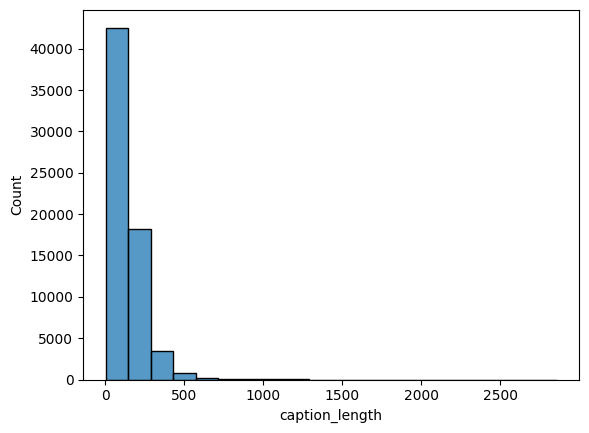

In [7]:
df_train['caption_length'] = df_train['caption'].apply(len)  # Compute caption lengths
sns.histplot(df_train['caption_length'], bins=20)  # Plot histogram of caption lengths


In [8]:
# Download necessary NLTK data
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [11]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    # Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [13]:
# Apply preprocessing to the 'caption' column
df_train['caption_text'] = df_train['caption'].apply(preprocess_text)

In [14]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption_text'].str.contains('chest xray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

id                                        name  \
69   ROCO_00087            PMC5144533_IJCCM-20-677-g002.jpg   
90   ROCO_00110              PMC4929806_CCR3-4-682-g003.jpg   
141  ROCO_00172               PMC4863054_ir-14-187-g002.jpg   
180  ROCO_00232            PMC4093973_IJCIIS-4-186-g001.jpg   
215  ROCO_00274  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                               caption  caption_length  \
69    Chest X-ray, which confirmed the position of ...             129   
90         Neonatal chest X‐ray of the larger fetus.\n              43   
141   Chest X-ray findings. Chest radiograph reveal...             206   
180   Chest X-ray, PA, showing the position of the ...              56   
215    Chest x-ray showing right-sided pneumothorax.\n              47   

                                          caption_text  
69   chest xray confirm posit guidewir extend right...  
90                       neonat chest xray larger fetu  
141  chest xray find chest radiograph reveal engorg...  
180                  chest xray pa show posit gun nail  
215              chest xray show rightsid pneumothorax

In [53]:
# Create "images" column to create full path for images
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

/tmp/ipykernel_34/1067852196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']


id                                        name  \
69   ROCO_00087            PMC5144533_IJCCM-20-677-g002.jpg   
90   ROCO_00110              PMC4929806_CCR3-4-682-g003.jpg   
141  ROCO_00172               PMC4863054_ir-14-187-g002.jpg   
180  ROCO_00232            PMC4093973_IJCIIS-4-186-g001.jpg   
215  ROCO_00274  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                               caption  caption_length  \
69    Chest X-ray, which confirmed the position of ...             129   
90         Neonatal chest X‐ray of the larger fetus.\n              43   
141   Chest X-ray findings. Chest radiograph reveal...             206   
180   Chest X-ray, PA, showing the position of the ...              56   
215    Chest x-ray showing right-sided pneumothorax.\n              47   

                                          caption_text  \
69   chest xray confirm posit guidewir extend right...   
90                       neonat chest xray larger fetu   
141  chest xray find chest radiograph reveal engorg...   
180                  chest xray pa show posit gun nail   
215              chest xray show rightsid pneumothorax   

                                                images  
69   /kaggle/input/roco-dataset/all_data/train/radi...  
90   /kaggle/input/roco-dataset/all_data/train/radi...  
141  /kaggle/input/roco-dataset/all_data/train/radi...  
180  /kaggle/input/roco-dataset/all_data/train/radi...  
215  /kaggle/input/roco-dataset/all_data/train/radi...

In [52]:
# Create new directory for training images
folder_path = "/kaggle/working/train"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)


In [54]:
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

In [56]:
filtered_df2=filtered_df

In [55]:
filtered_df.head()

id                                        name  \
69   ROCO_00087            PMC5144533_IJCCM-20-677-g002.jpg   
90   ROCO_00110              PMC4929806_CCR3-4-682-g003.jpg   
141  ROCO_00172               PMC4863054_ir-14-187-g002.jpg   
180  ROCO_00232            PMC4093973_IJCIIS-4-186-g001.jpg   
215  ROCO_00274  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                               caption  caption_length  \
69    Chest X-ray, which confirmed the position of ...             129   
90         Neonatal chest X‐ray of the larger fetus.\n              43   
141   Chest X-ray findings. Chest radiograph reveal...             206   
180   Chest X-ray, PA, showing the position of the ...              56   
215    Chest x-ray showing right-sided pneumothorax.\n              47   

                                          caption_text  \
69   chest xray confirm posit guidewir extend right...   
90                       neonat chest xray larger fetu   
141  chest xray find chest radiograph reveal engorg...   
180                  chest xray pa show posit gun nail   
215              chest xray show rightsid pneumothorax   

                                                images  
69   /kaggle/input/roco-dataset/all_data/train/radi...  
90   /kaggle/input/roco-dataset/all_data/train/radi...  
141  /kaggle/input/roco-dataset/all_data/train/radi...  
180  /kaggle/input/roco-dataset/all_data/train/radi...  
215  /kaggle/input/roco-dataset/all_data/train/radi...

In [83]:
# Delete extra column from the dataframe
filtered_df = filtered_df.drop(columns=["images", "id","caption_length"])


KeyError: "['images'] not found in axis"

In [22]:
filtered_df = filtered_df.drop(columns=["caption"])

In [23]:
filtered_df.head()

name  \
69             PMC5144533_IJCCM-20-677-g002.jpg   
90               PMC4929806_CCR3-4-682-g003.jpg   
141               PMC4863054_ir-14-187-g002.jpg   
180            PMC4093973_IJCIIS-4-186-g001.jpg   
215  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                          caption_text  
69   chest xray confirm posit guidewir extend right...  
90                       neonat chest xray larger fetu  
141  chest xray find chest radiograph reveal engorg...  
180                  chest xray pa show posit gun nail  
215              chest xray show rightsid pneumothorax

In [25]:
# Convert dataframe to json format
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption_text"]}, axis=1).tolist()

In [26]:
# Save data to json file
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))

In [27]:
dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
dataset

Resolving data files:   0%|          | 0/1781 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 1780
})

In [ ]:
# Visualize the first images and its caption from training data
example = dataset[0]
image = example["image"]
width, height = image.size
print(example["text"])
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/git-large-textcaps")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-textcaps")

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [ ]:
train_dataset

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
train_dataloader

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
    print("Epoch:", epoch)
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False)
    for idx, batch in enumerate(progress_bar):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())  # Update progress bar

    print("Loss:", loss.item())


In [ ]:
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)


In [ ]:
load_model = AutoModelForCausalLM.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

In [75]:
# Creating Test Dataset

df_test = pd.read_csv('/kaggle/input/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
mask = df_test['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_test[mask]
filtered_df.head()
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']
filtered_df.head()
folder_path = "/kaggle/working/test"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)



/tmp/ipykernel_34/499300998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']


In [76]:
filtered_df.head()

id                                  name  \
18   ROCO_00264       PMC3160360_1749-7922-6-23-1.jpg   
39   ROCO_00454       PMC3487871_1746-1596-7-67-1.jpg   
130  ROCO_01468        PMC2700561_JETS-01-34-g001.jpg   
137  ROCO_01552       PMC4230561_rado-48-04-397f6.jpg   
181  ROCO_01935  PMC5674496_CRIID2017-5358095.002.jpg   

                                               caption  \
18    Initial chest x-ray showing a left tension pn...   
39    The chest X-ray showed mild increase of trans...   
130   Chest X-Ray showing pneumothorax secondary to...   
137   Chest x-ray demonstrates high position of the...   
181   Second chest X-ray (after 48 hours). Right-si...   

                                                images  
18   /kaggle/input/roco-dataset/all_data/test/radio...  
39   /kaggle/input/roco-dataset/all_data/test/radio...  
130  /kaggle/input/roco-dataset/all_data/test/radio...  
137  /kaggle/input/roco-dataset/all_data/test/radio...  
181  /kaggle/input/roco-dataset/all_data/test/radio...

In [ ]:
filtered_df = filtered_df.drop(columns=["images", "id"])
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()
# add metadata.jsonl file to this folder
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
test_dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
test_dataset

In [ ]:
import matplotlib.pyplot as plt

# Counter to display only 10 images
count = 0

# Iterate through the test dataset and generate captions for each image
for example in test_dataset:
    if count == 10:
        break  # Exit loop after displaying 10 images
    
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Create a new figure for each image and caption
    fig = plt.figure(figsize=(12, 6))  # Set the size of the figure
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image")  # Title for the image
    plt.show()

    # Display the generated caption
    print("Generated Caption:", generated_caption)
    
    count += 1  # Increment counter after displaying each image


Model 2

In [46]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [118]:
image_path = '/kaggle/input/roco-dataset/all_data/train/radiology/images'

In [124]:
# mask = df_train['caption_text'].str.contains('xray', case=False)
filtered_df2 = df_train.sample(n=15000, random_state=42) 

In [125]:
filtered_df2.shape

(15000, 5)

In [126]:
filtered_df2 = filtered_df2.drop(columns=[ "id","caption_length","caption"])

In [127]:
filtered_df2.head()

name  \
18521          PMC4852590_kjn-10-31-g001.jpg   
36906    PMC5155106_CRIS2016-5365647.001.jpg   
56991                   PMC5587902_fig-2.jpg   
44087  PMC3886584_CRIM.EM2013-587018.003.jpg   
22000           PMC3663152_IPC-14-1-g002.jpg   

                                            caption_text  
18521  brain ct scan show epidur hematoma contus righ...  
36906  initi iliac crest bone harvest procedur postop...  
56991  demonstr larg locul rim enhanc right retroperi...  
44087  bedsid ultrasound demonstr hyperecho object wi...  
22000  imag echo imag modifi parastern long axi view ...

In [128]:
data=filtered_df2

In [129]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/roco-dataset/all_data/train/radiology/images/{temp_df.name[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption_text[i], 20)))
        plt.axis("off")

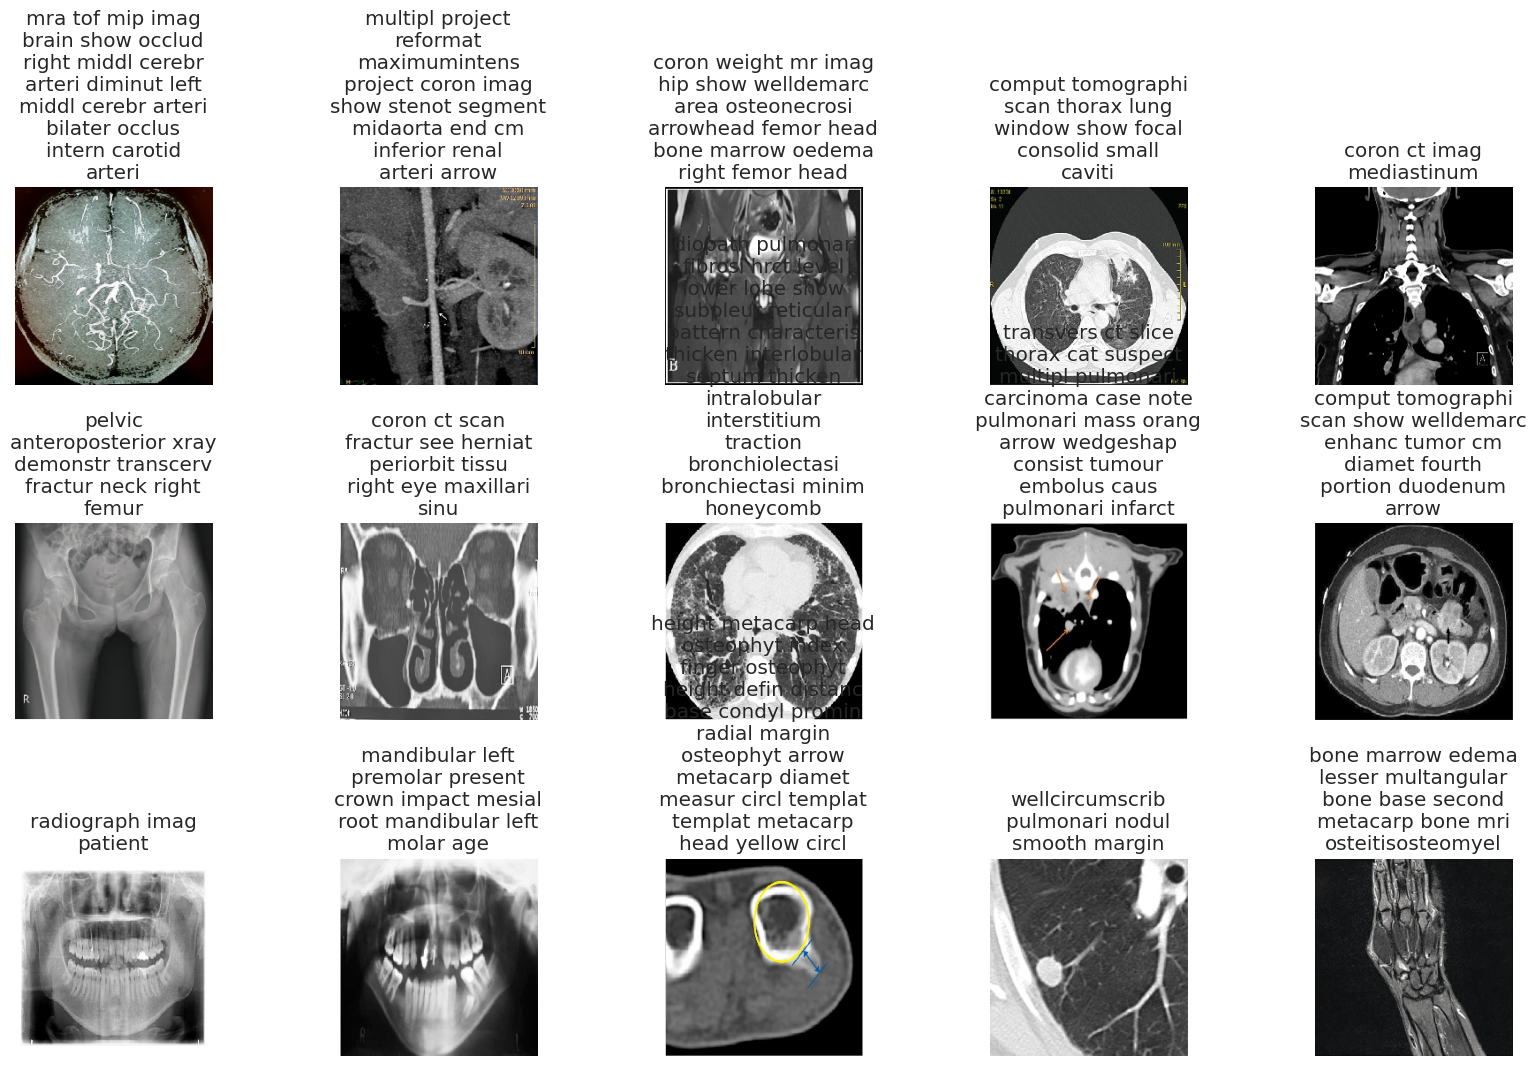

In [130]:
display_images(data.sample(15))

In [131]:
def text_preprocessing(data):
    data['caption_text'] = data['caption_text'].apply(lambda x: x.lower())
    data['caption_text'] = data['caption_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Using regex for replacing non-alphabetic characters
    data['caption_text'] = data['caption_text'].apply(lambda x: re.sub(r'\s+', ' ', x))  # Replace multiple spaces with single space
    data['caption_text'] = data['caption_text'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))  # Remove single character words
    data['caption_text'] = "startseq " + data['caption_text'] + " endseq"  # Adding startseq and endseq tokens
    return data


In [132]:
data = text_preprocessing(data)

In [133]:
captions = data['caption_text'].tolist()
captions[:10]

['startseq brain ct scan show epidur hematoma contus right tempor region endseq',
 'startseq initi iliac crest bone harvest procedur postop radiograph demonstr rel posit incis closur stapl endseq',
 'startseq demonstr larg locul rim enhanc right retroperiton fluid collect arrow endseq',
 'startseq bedsid ultrasound demonstr hyperecho object within bladder endseq',
 'startseq imag echo imag modifi parastern long axi view show ventricular noncompact rv right ventricl ventricular noncompact endseq',
 'startseq chest ct imag patient endseq',
 'startseq radiographi postopratoir apr laminectomi dcompress et stabilis du rachi dorsal par instrument postrieur endseq',
 'startseq background elimin red channel de rgb space endseq',
 'startseq cm nodular lesion left lower pole kidney arrow endseq',
 'startseq grayscal ultrasonographi patient transplant kidney month surgeri endseq']

In [134]:
data.head()

name  \
18521          PMC4852590_kjn-10-31-g001.jpg   
36906    PMC5155106_CRIS2016-5365647.001.jpg   
56991                   PMC5587902_fig-2.jpg   
44087  PMC3886584_CRIM.EM2013-587018.003.jpg   
22000           PMC3663152_IPC-14-1-g002.jpg   

                                            caption_text  
18521  startseq brain ct scan show epidur hematoma co...  
36906  startseq initi iliac crest bone harvest proced...  
56991  startseq demonstr larg locul rim enhanc right ...  
44087  startseq bedsid ultrasound demonstr hyperecho ...  
22000  startseq imag echo imag modifi parastern long ...

In [135]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['name'].isin(train_images)]
test = data[data['name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 196, 253, 1150, 38, 3186, 551, 51, 10, 19, 632, 99, 1587, 1064, 2091, 2]

In [136]:
# model = DenseNet201()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# features = {}
# for image in tqdm(data['name'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[image] = feature
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}

for image in tqdm(data['name'].unique().tolist()):
    try:
        img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        feature = fe.predict(img, verbose=0)
        features[image] = feature
    except FileNotFoundError:
        pass

# Continue with further processing after the loop
# For example, save features to a file or train a classifier
# ...


100%|██████████| 15000/15000 [25:38<00:00,  9.75it/s] 


In [141]:
# class CustomDataGenerator(Sequence):
    
#     def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
#                  vocab_size, max_length, features,shuffle=True):
    
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.directory = directory
#         self.batch_size = batch_size
#         self.tokenizer = tokenizer
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.features = features
#         self.shuffle = shuffle
#         self.n = len(self.df)
        
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)
    
#     def __len__(self):
#         return self.n // self.batch_size
    
#     def __getitem__(self,index):
    
#         batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
#         X1, X2, y = self.__get_data(batch)        
#         return (X1, X2), y
    
#     def __get_data(self,batch):
        
#         X1, X2, y = list(), list(), list()
        
#         images = batch[self.X_col].tolist()
           
#         for image in images:
#             feature = self.features[image][0]
            
#             captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
#             for caption in captions:
#                 seq = self.tokenizer.texts_to_sequences([caption])[0]

#                 for i in range(1,len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
#                     out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
#                     X1.append(feature)
#                     X2.append(in_seq)
#                     y.append(out_seq)
            
#         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
#         return X1, X2, y
import numpy as np
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# class CustomDataGenerator(Sequence):
    
#     def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
#                  vocab_size, max_length, features, shuffle=True):
    
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.directory = directory
#         self.batch_size = batch_size
#         self.tokenizer = tokenizer
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.features = features
#         self.shuffle = shuffle
#         self.n = len(self.df)
        
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)
    
#     def __len__(self):
#         return self.n // self.batch_size
    
#     def __getitem__(self, index):
#         batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
#         X1, X2, y = self.__get_data(batch)
#         return (X1, X2), y
    
#     def __get_data(self, batch):
#         X1, X2, y = [], [], []
        
#         for _, row in batch.iterrows():
#             image = row[self.X_col]
#             caption = row[self.y_col]
            
#             # Check if the image exists in features
#             if image in self.features:
#                 feature = self.features[image][0]
#                 seq = self.tokenizer.texts_to_sequences([caption])[0]
                
#                 for i in range(1, len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
#                     out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
#                     X1.append(feature)
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             else:
#                 print(f"Warning: Feature vector for image {image} not found. Skipping this sample.")
        
#         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#         return X1, X2, y
import numpy as np
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        
        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]
            
            try:
                # Check if the image exists in features
                if image in self.features:
                    feature = self.features[image][0]
                    seq = self.tokenizer.texts_to_sequences([caption])[0]
                    
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)
                else:
                    print(f"Warning: Feature vector for image {image} not found. Skipping this sample.")
            
            except KeyError:
                print(f"Warning: Image {image} not found in features. Skipping this sample.")
                continue
        
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


In [142]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [143]:
from tensorflow.keras.utils import plot_model

In [144]:
caption_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    491,776 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 205)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 256)    │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 205, 256)  │  3,497,472 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 206, 256)  │          0 │ reshape_4[0][0],  │
│ (Concatenate)       │                   │            │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dropout_8[0][0],  │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 13662)     │  1,762,398 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,309,854 (24.07 MB)

 Trainable params: 6,309,854 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
# train_generator = CustomDataGenerator(df=train,X_col='name',y_col='caption_text',batch_size=64,directory=image_path,
#                                       tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# validation_generator = CustomDataGenerator(df=test,X_col='name',y_col='caption_text',batch_size=64,directory=image_path,
#                                       tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)
train_generator = CustomDataGenerator(
    df=train,
    X_col='name',  # Assuming 'name' column contains image filenames
    y_col='caption_text',  # Assuming 'caption_text' column contains captions
    batch_size=64,
    directory=image_path,  # Directory where images are located
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features  # Assuming this is a dictionary mapping filenames to features
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='name',  # Assuming 'name' column contains image filenames
    y_col='caption_text',  # Assuming 'caption_text' column contains captions
    batch_size=64,
    directory=image_path,  # Directory where images are located
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features  # Assuming this is a dictionary mapping filenames to features
)


In [146]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [147]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
 43/199 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - loss: 8.3369Warning: Feature vector for image PMC2892771_yjbm_83_2_67_g01.jpg not found. Skipping this sample.
 83/199 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - loss: 7.9562Warning: Feature vector for image PMC4603610_amjcaserep-16-715-g002.jpg not found. Skipping this sample.
133/199 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 7.7166Warning: Feature vector for image PMC3999928_f1000research-3-4060-g0002.jpg not found. Skipping this sample.
143/199 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 7.6822Warning: Feature vector for image PMC5218828_nihms839236f3.jpg not found. Skipping this sample.
144/199 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 7.6789Warning: Feature vector for image PMC2946122_yjbm_83_3_113_g01.jpg not found. Skipping this sample.
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 7.5326
Epoch 1: val_loss improved from inf to 6.61922, saving model to model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - loss: 7.53

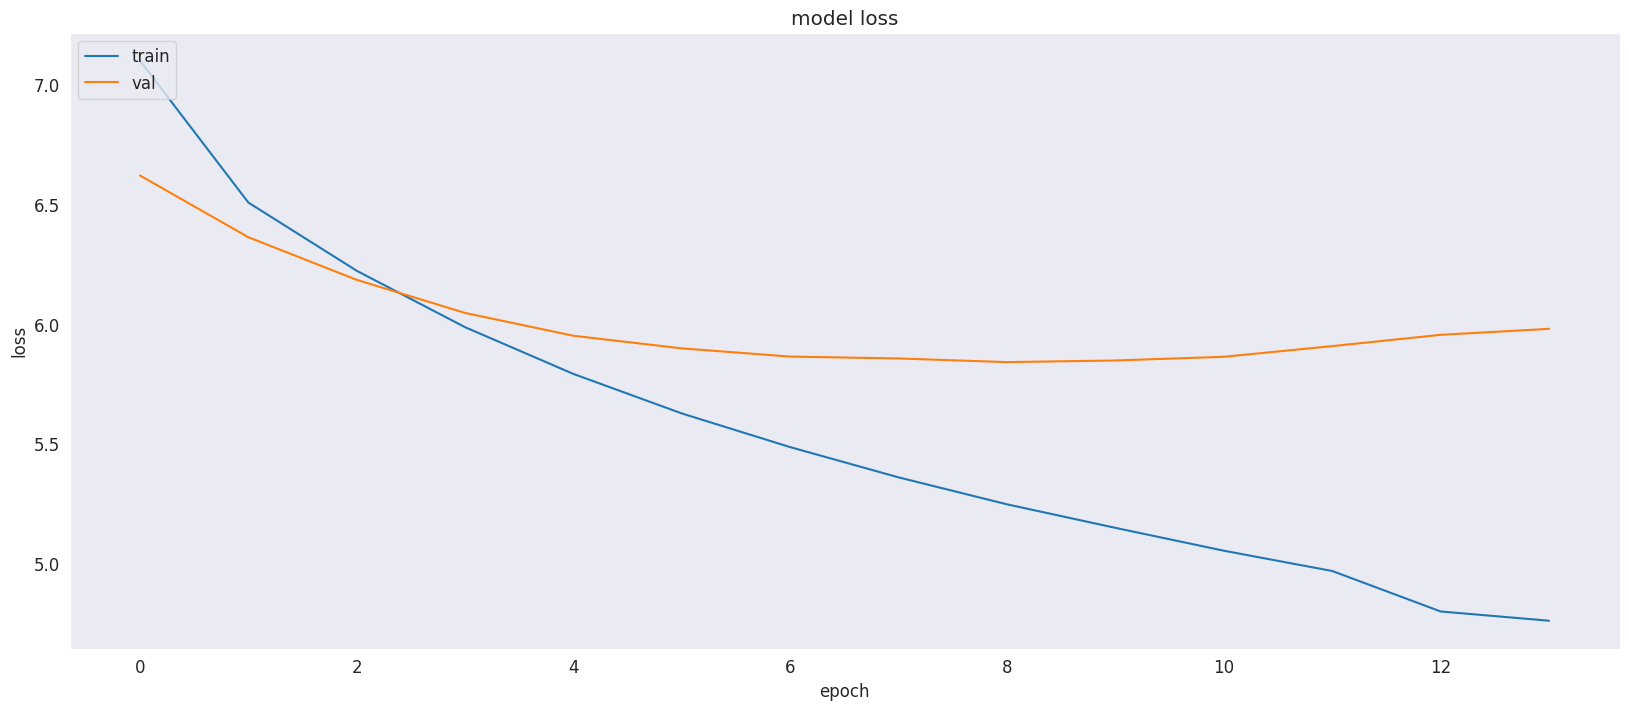

In [148]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [149]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [150]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [156]:
samples = test.sample(1500)
samples.reset_index(drop=True,inplace=True)

In [157]:
samples

name  \
0                         PMC4334645_gr1.jpg   
1         PMC5021833_VetWorld-9-842-g003.jpg   
2          PMC3303615_DRT2012-485249.001.jpg   
3       PMC4397027_CRIONM2015-947040.002.jpg   
4             PMC3214412_IJO-59-431-g004.jpg   
...                                      ...   
1495          PMC3772293_jkns-54-68-g002.jpg   
1496        PMC2517617_pmed.0050176.g001.jpg   
1497                      PMC4811991_gr2.jpg   
1498                      PMC3920430_gr1.jpg   
1499  PMC4837624_12947_2016_58_Fig6_HTML.jpg   

                                           caption_text  
0        startseq pelvic xray foreign bodi pelvi endseq  
1     startseq transabdomin sonograph imag heart fet...  
2     startseq posit hippocamp voxel sampl magnet re...  
3     startseq magnet reson imag mri show complex in...  
4     startseq ultrasound bscan imag orbit abscess w...  
...                                                 ...  
1495  startseq preoper brain ct show moder amount cr...  
1496  startseq chest radiograph infant pulmonari tub...  
1497  startseq anteroposterior radiograph right shou...  
1498          startseq computer chest tomographi endseq  
1499                          startseq tap group endseq  

[1500 rows x 2 columns]

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['name']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['name'], tokenizer, max_length, features)
    samples.loc[index,'predict_caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

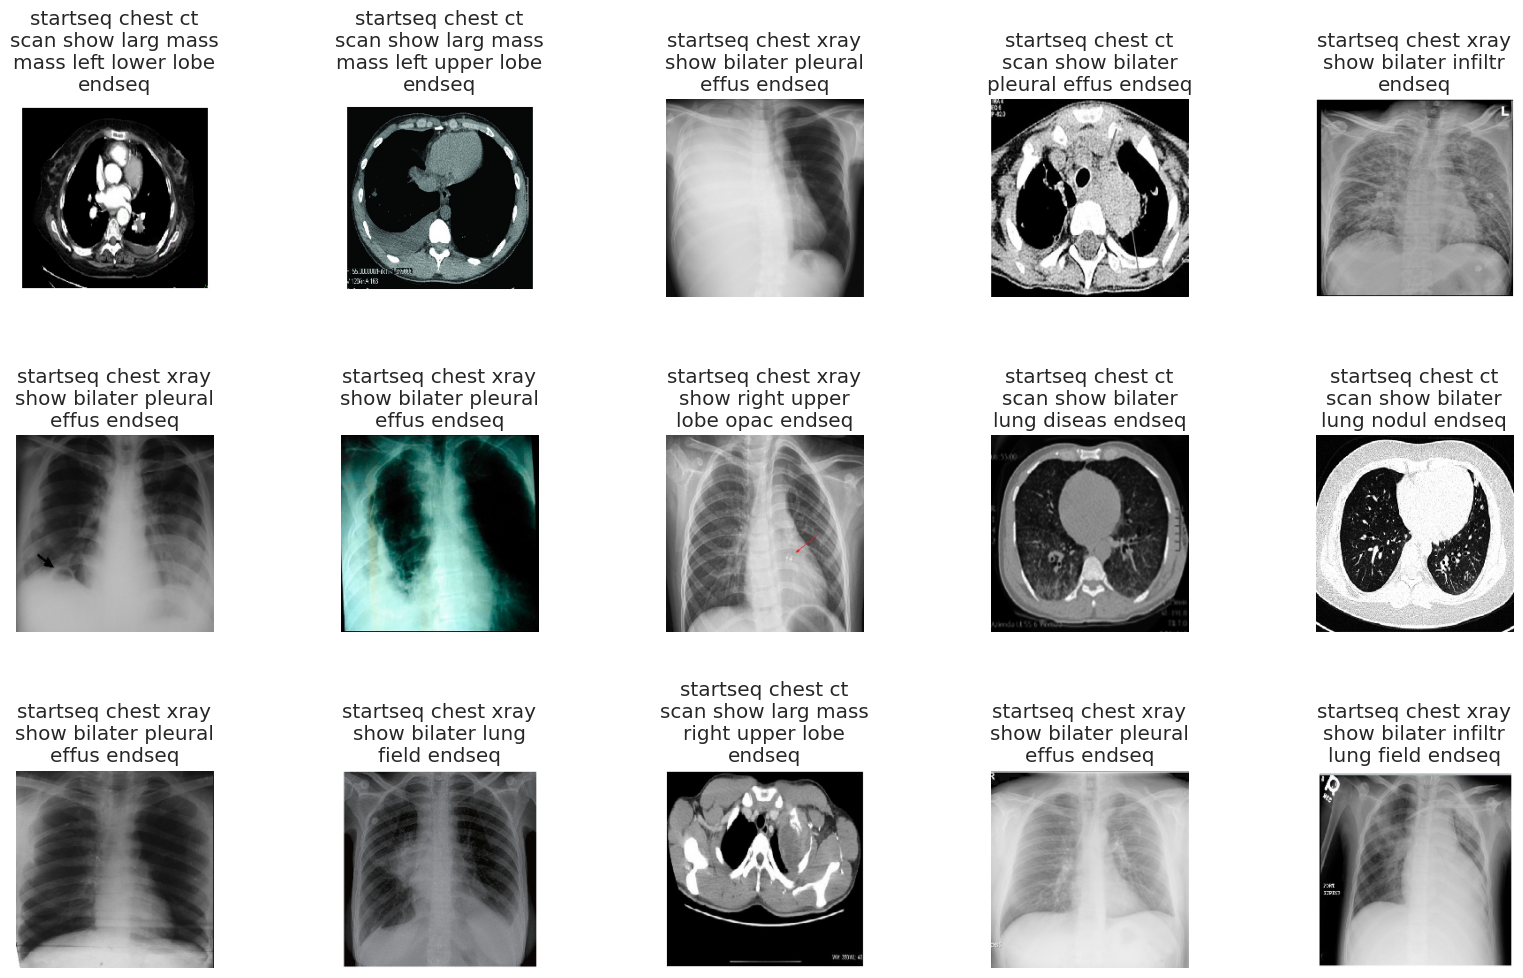

In [96]:
display_images(samples)


In [115]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 23.9 MB/s eta 0:00:00


In [ ]:
import nltk
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

# Ensure you have downloaded necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

def evaluate_model(df):
    actual = df['caption_text'].apply(lambda x: x.split())
    predicted = df['predict_caption'].apply(lambda x: x.split())
    
    # BLEU score
    bleu_score = calculate_bleu(actual, predicted)
    print(f"BLEU score: {bleu_score}")

    # METEOR, ROUGE, and CIDEr scores
    meteor_score = calculate_meteor(actual, predicted)
    print(f"METEOR score: {meteor_score}")
    
    rouge_score = calculate_rouge(actual, predicted)
    print(f"ROUGE score: {rouge_score}")
    
    cider_score = calculate_cider(actual, predicted)
    print(f"CIDEr score: {cider_score}")

def calculate_bleu(references, candidates):
    references = [[ref] for ref in references]
    smoothing_function = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothing_function)

def calculate_meteor(references, candidates):
    scorer = Meteor()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)

def calculate_rouge(references, candidates):
    scorer = Rouge()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)

def calculate_cider(references, candidates):
    scorer = Cider()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)

# Example usage
# Assuming your DataFrame is named `df`
evaluate_model(samples)


Model 3

In [17]:
import os
import time
import shutil
import pathlib
import itertools
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
import cv2
import matplotlib.patches as patches
import random
from tensorflow.keras.utils import Sequence
from IPython.display import Image
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu
import gc
import requests
from io import BytesIO

In [25]:
BASE_DIR = '/kaggle/input/roco-dataset/all_data/train/radiology'
WORKING_DIR = '/kaggle/working/'

In [18]:
# mask = df_train['caption_text'].str.contains('xray', case=False)
filtered_df3 = df_train.sample(n=5000, random_state=42) 

In [28]:
image_names = filtered_df3['name'].tolist()

In [19]:
base_model = Xception(weights='imagenet', include_top=False) #with imagenet weights

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
x = base_model.output # since xception does not have any fully connected layers 
x = GlobalAveragePooling2D()(x) # added a avg pooling layer
model = Model(inputs=base_model.input, outputs=x)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [30]:
features = {}
directory = os.path.join(BASE_DIR, 'images')
for img_name in tqdm(image_names):
    try:
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(299, 299))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/5000 [00:00<?, ?it/s]

Error processing PMC5218828_nihms839236f3.jpg: [Errno 2] No such file or directory: '/kaggle/input/roco-dataset/all_data/train/radiology/images/PMC5218828_nihms839236f3.jpg'


In [31]:
#Load features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [32]:
#Load Captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [37]:
filtered_df3.head()

id                                   name  \
18521  ROCO_23122          PMC4852590_kjn-10-31-g001.jpg   
36906  ROCO_46080    PMC5155106_CRIS2016-5365647.001.jpg   
56991  ROCO_71189                   PMC5587902_fig-2.jpg   
44087  ROCO_55036  PMC3886584_CRIM.EM2013-587018.003.jpg   
22000  ROCO_27429           PMC3663152_IPC-14-1-g002.jpg   

                                                 caption  caption_length  \
18521   Brain CT scan showing an epidural hematoma an...              88   
36906   Initial iliac crest bone harvest procedure po...             135   
56991   Demonstration of large, loculated rim enhanci...              97   
44087   Bedside ultrasound demonstrating hyperechoic ...              73   
22000   2D image echo image (modified parasternal lon...             146   

                                            caption_text  
18521  brain ct scan show epidur hematoma contus righ...  
36906  initi iliac crest bone harvest procedur postop...  
56991  demonstr larg locul rim enhanc right retroperi...  
44087  bedsid ultrasound demonstr hyperecho object wi...  
22000  imag echo imag modifi parastern long axi view ...

In [38]:
from tqdm import tqdm

# Initialize the mapping dictionary
mapping = {}

# Iterate over the rows of your DataFrame `filtered_df3`
for _, row in tqdm(filtered_df3.iterrows(), total=filtered_df3.shape[0]):
    image_id = row['name'].split('.')[0]  # Adjust this column name if needed
    caption = row['caption']
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 5000/5000 [00:00<00:00, 15975.59it/s]


In [39]:
#function to clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [40]:
# Word2vector for vector embeddings of the text
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [41]:
# Create embedding matrix
embedding_dim = 512
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [42]:
max_length = max(len(caption) for caption in all_captions)
max_length

319

In [43]:
# Train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [44]:
# Data generator function
def data_generator(data_keys, mapping, features, word_index, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = [word_index[word] for word in caption.split() if word in word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [45]:
# Model architecture
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 319)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 319, 512)  │  7,332,864 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 319)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 319, 512)  │      2,048 │ embedding[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 14322)     │  7,347,186 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,839,090 (68.05 MB)

 Trainable params: 10,501,106 (40.06 MB)

 Non-trainable params: 7,337,984 (27.99 MB)

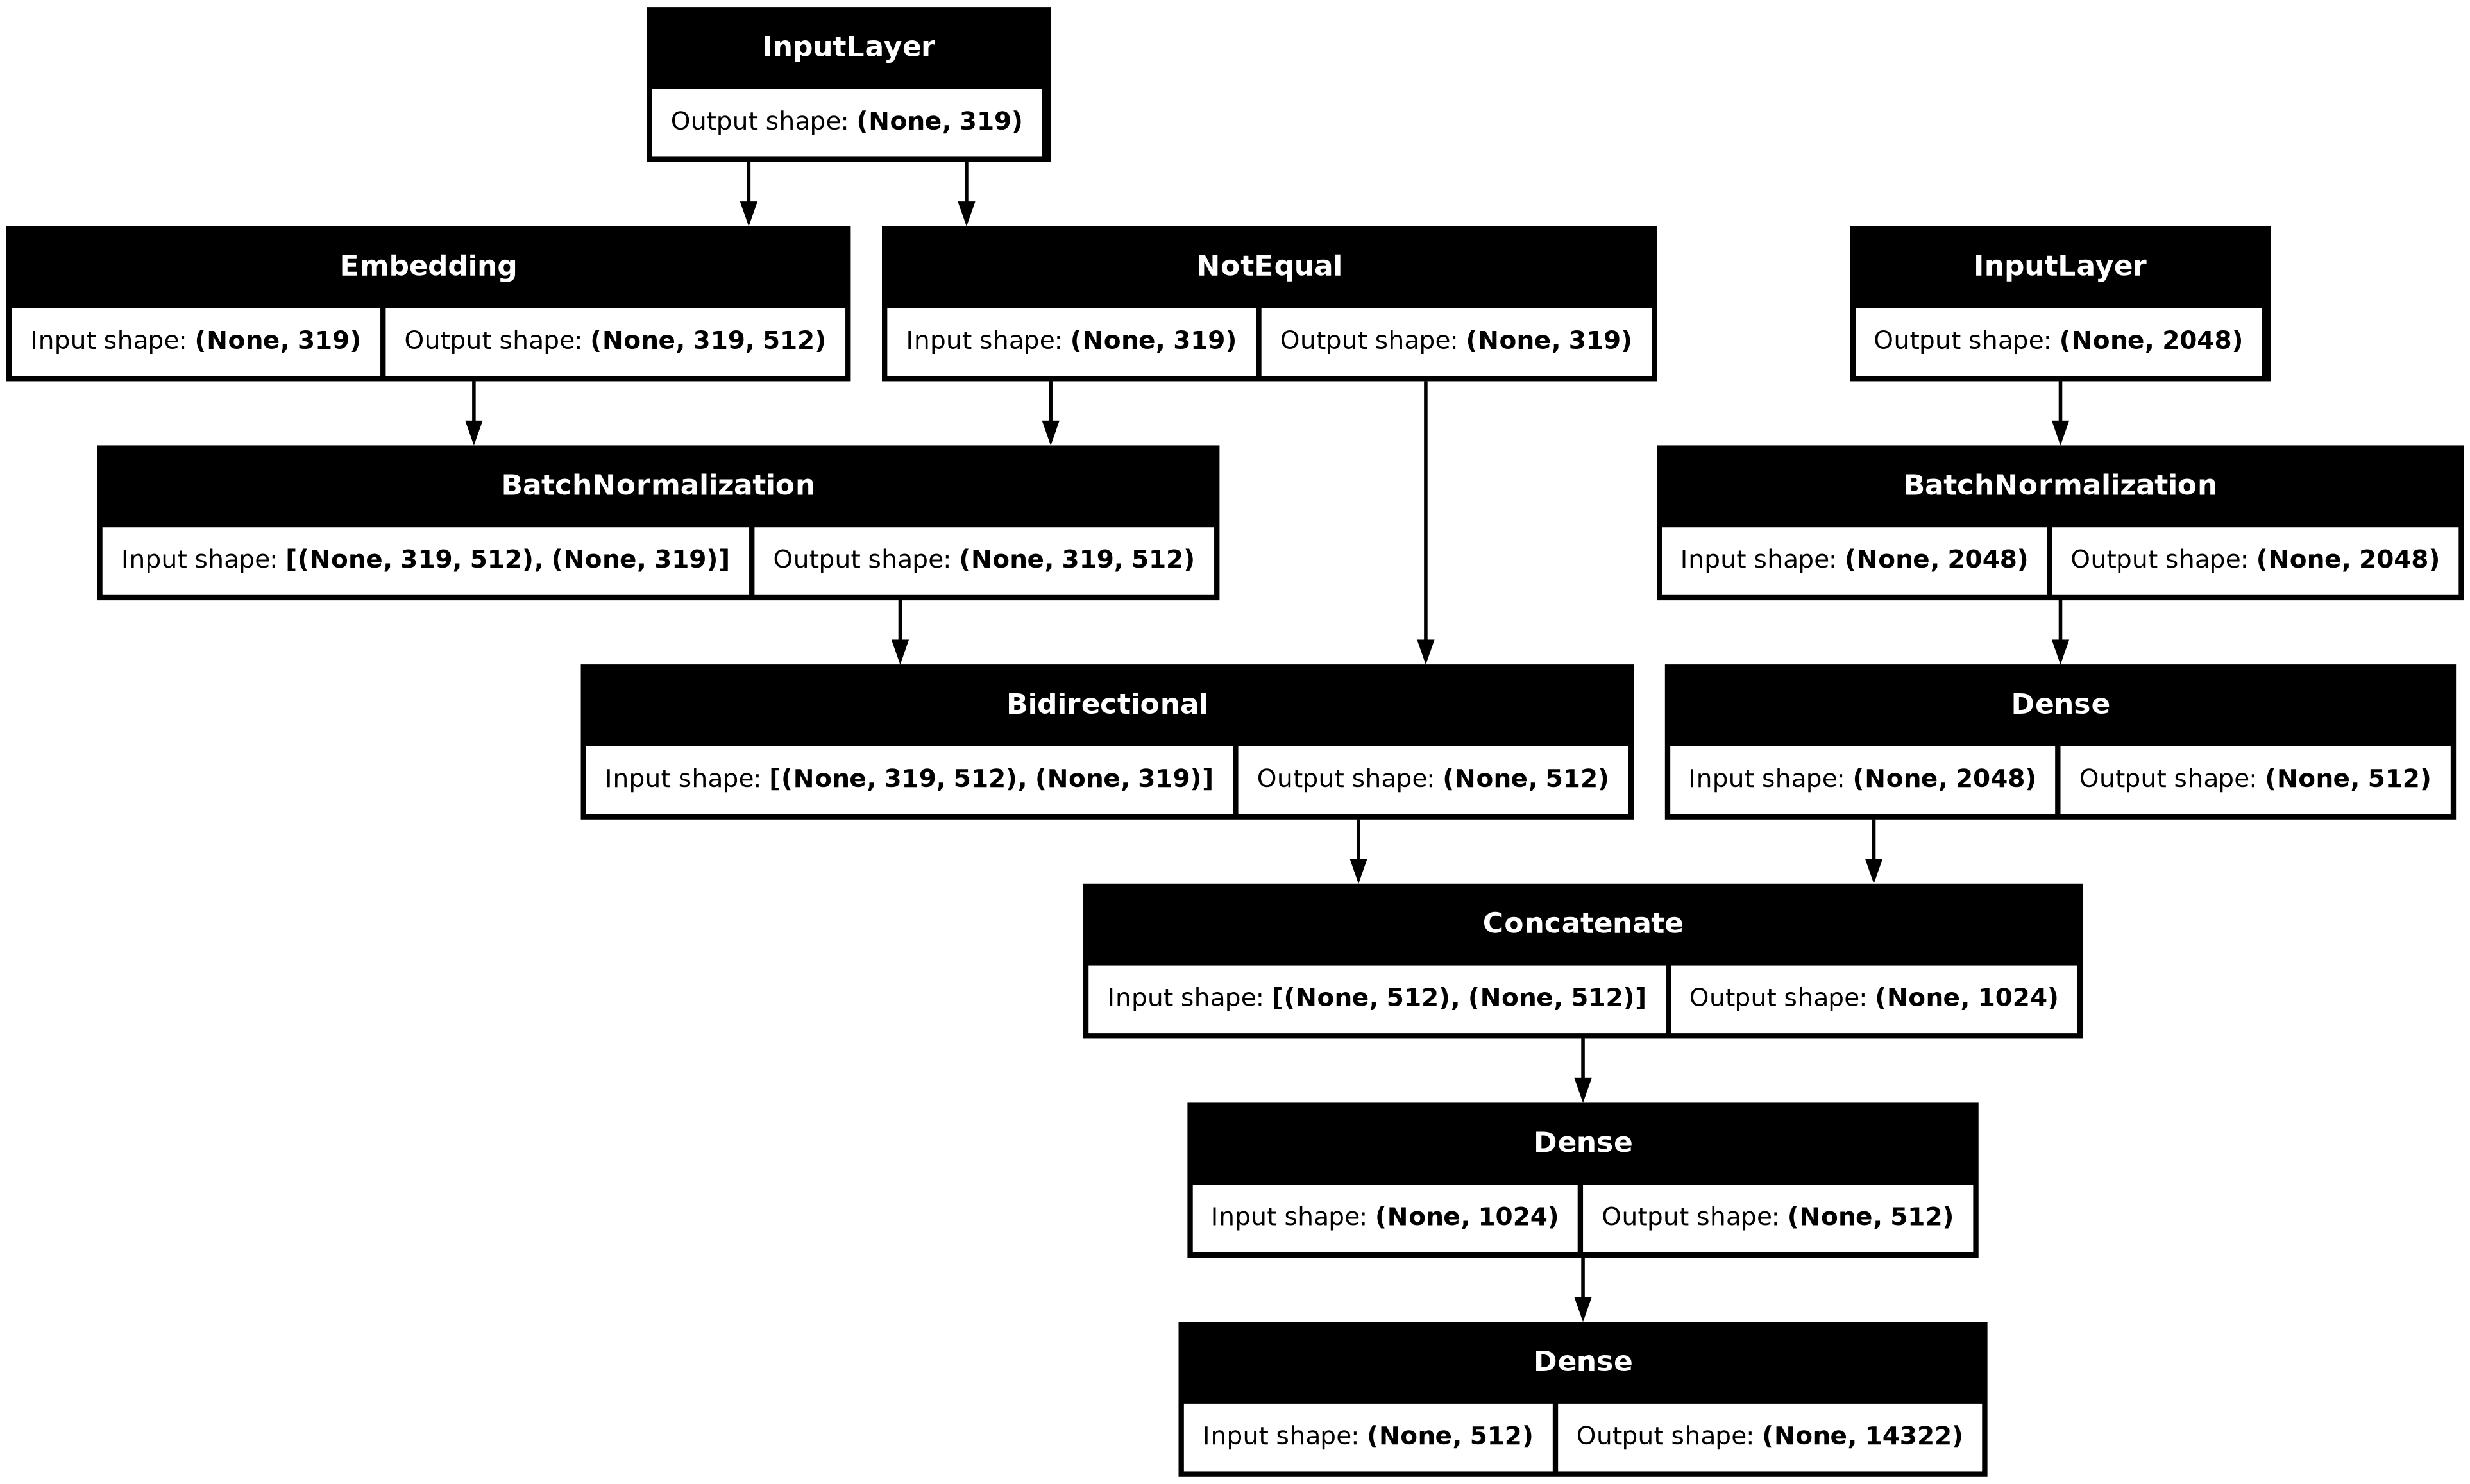

In [46]:
plot_model(model, show_shapes=True)

In [51]:
# Train the model
epochs = 10  #epochs > 64 causing memory error
batch_size = 32
steps = len(train) // batch_size
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [58]:
for i in range(epochs):
    generator = data_generator(train, mapping, features, word_index, max_length, vocab_size, batch_size)
    try:
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])
    except Exception as e:
        print(f". Skipping this epoch and continuing...")
        continue

   

 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.3457 - loss: 2.7306. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.3532 - loss: 2.6878. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.3636 - loss: 2.6332. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.3731 - loss: 2.5762. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.3787 - loss: 2.5214. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.3877 - loss: 2.4691. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.3925 - loss: 2.4198. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.3990 - loss: 2.3773. Skipping this epoch and continuing...
 91/139 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.4080 - loss: 2.

In [59]:
# Prediction functions
def idx_to_word(integer, word_index):
    for word, index in word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, word_index, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[word] for word in in_text.split() if word in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, word_index)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [61]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], word_index, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))

100%|██████████| 497/497 [13:46<00:00,  1.66s/it] 

BLEU-1: 0.089599


In [62]:
model.save(WORKING_DIR + '/model.keras')

In [76]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    # Check if image_id exists in features dictionary
    if image_id not in features:
        print(f"Image ID '{image_id}' not found in features dictionary.")
        return ""
    
    # Assuming predict_caption function is defined elsewhere
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    
    # Modify the caption to remove startseq and endseq tokens
    return y_pred.replace("startseq ", "").replace(" endseq", "")


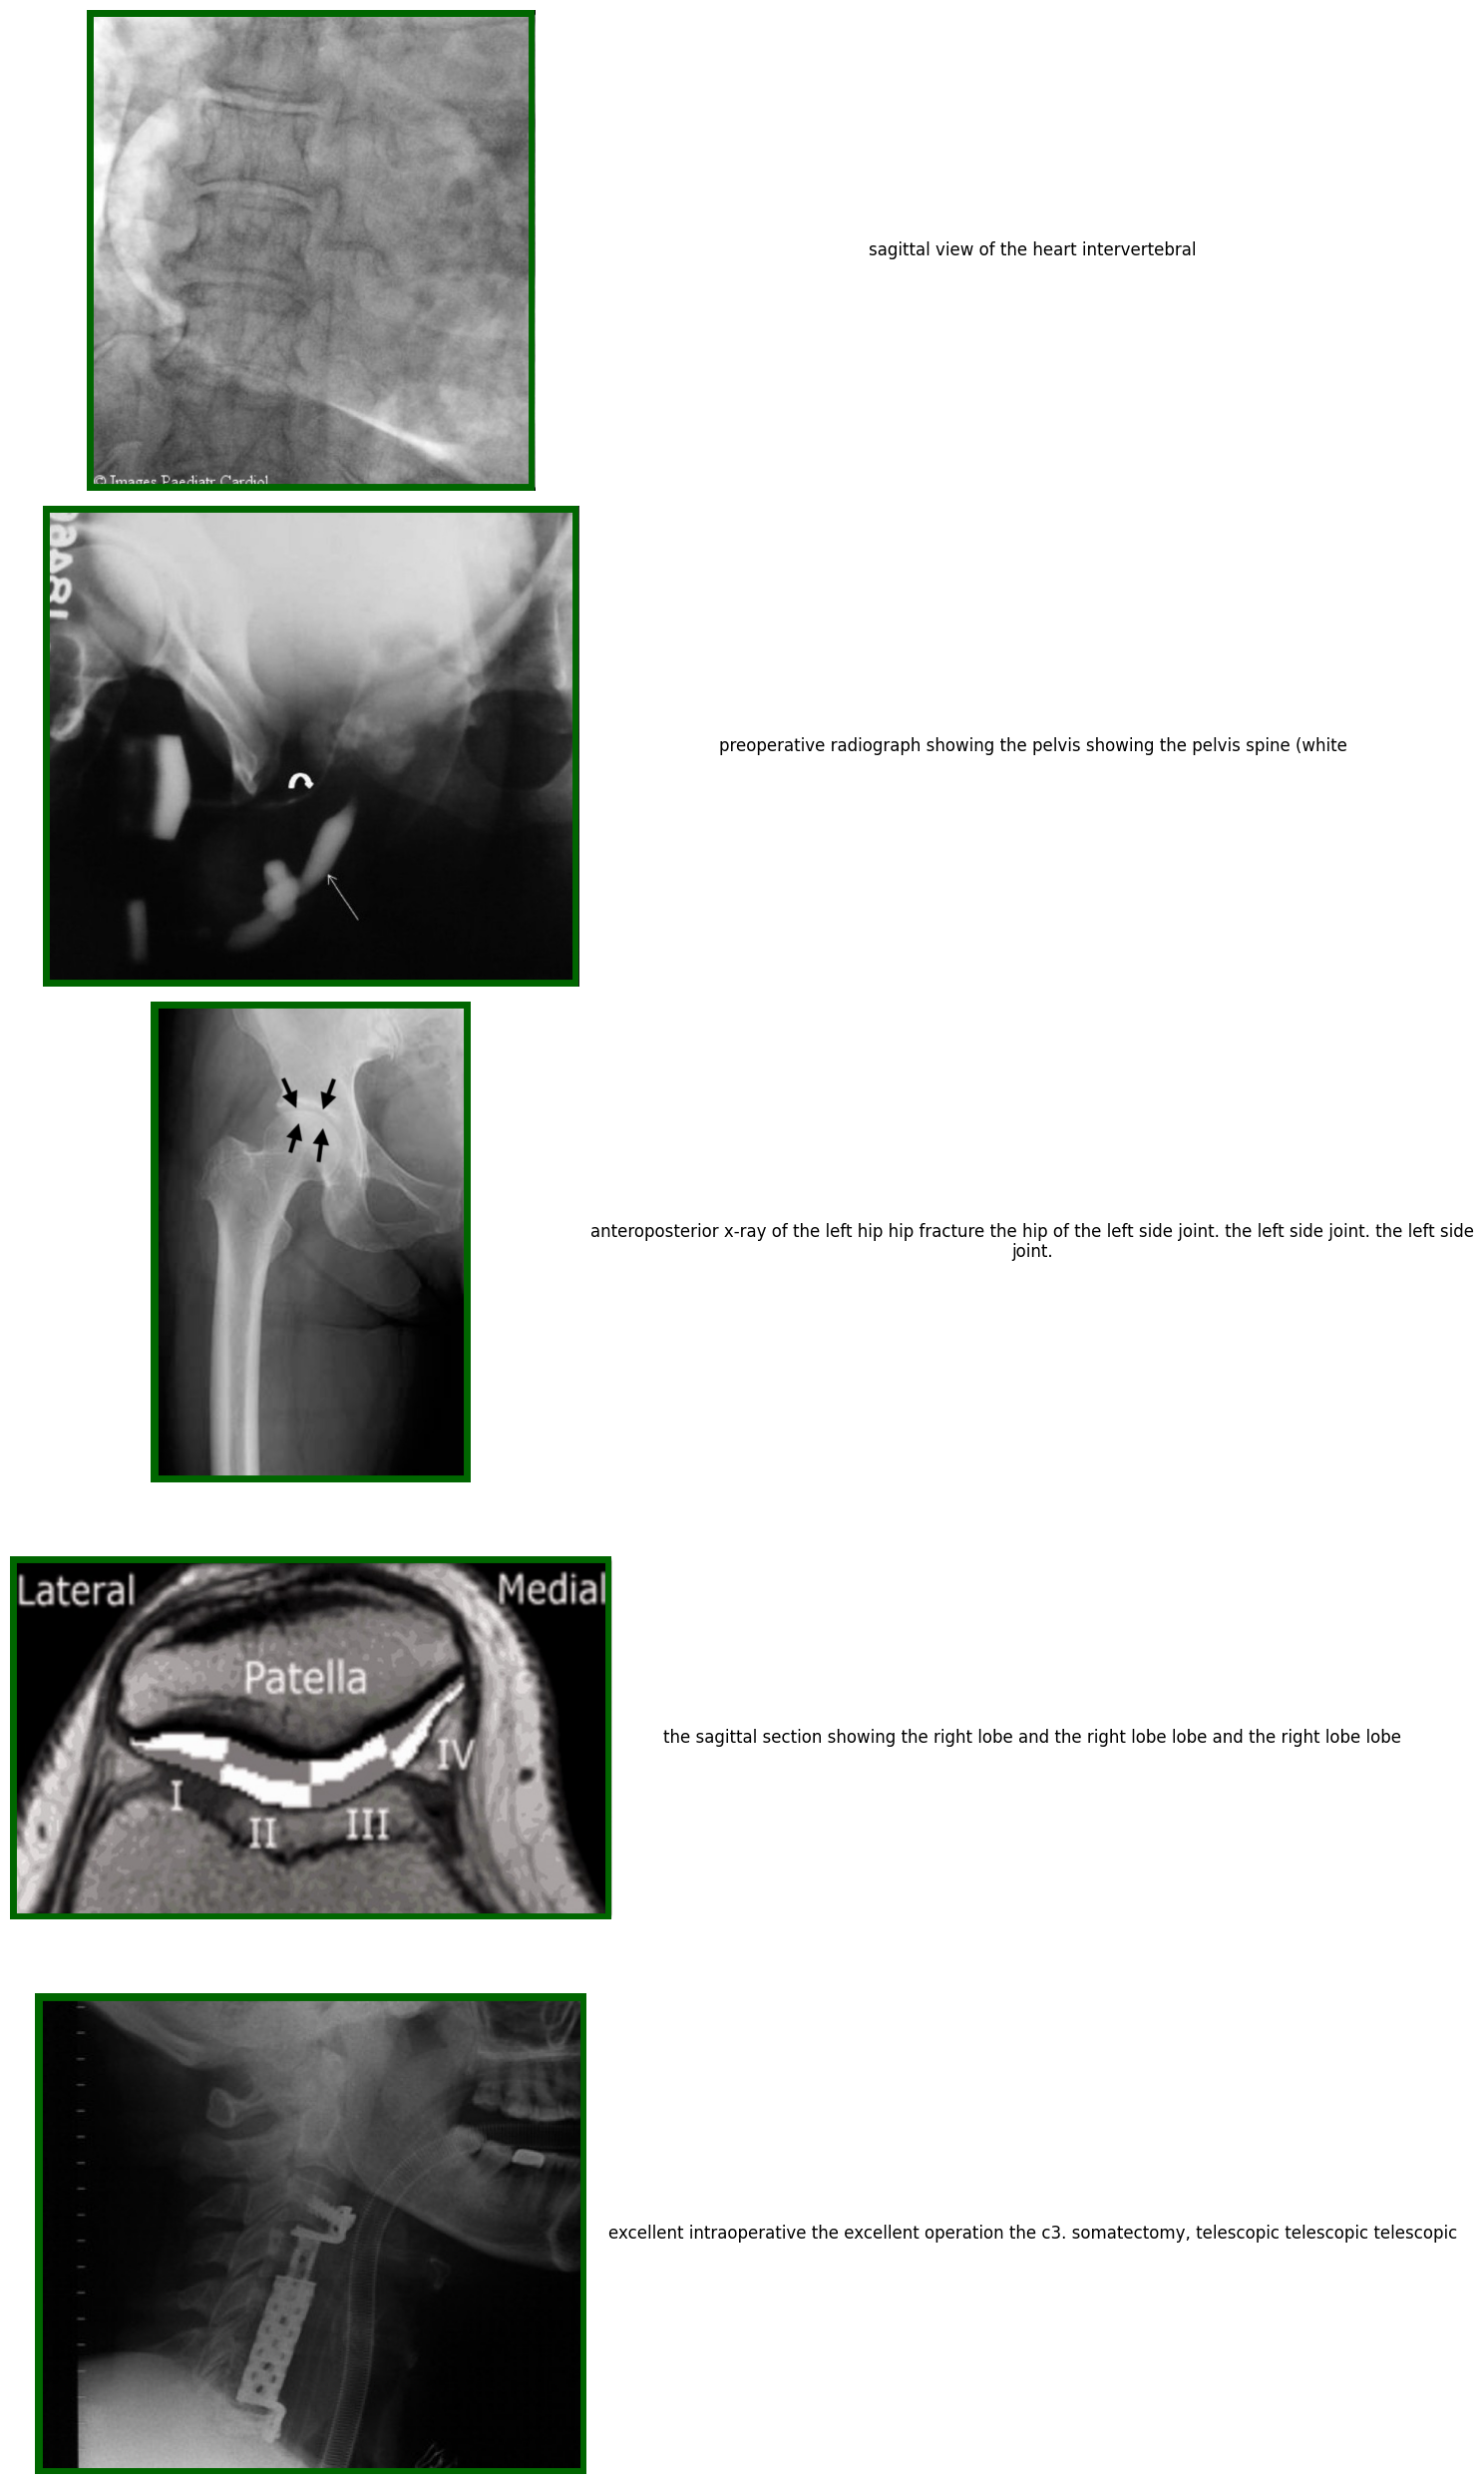

In [78]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def display_random_images_with_captions(directory, num_images=5):
    image_list = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    
    # Filter image_list based on keys present in features
    valid_images = [image_name for image_name in image_list if image_name.split('.')[0] in features]
    
    random_images = random.sample(valid_images, num_images)
    
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))
    
    for idx, image_name in enumerate(random_images):
        image_path = os.path.join(directory, image_name)
        image_id = image_name.split('.')[0]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        axes[idx, 0].imshow(image)
        axes[idx, 0].axis('off')
        
        rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, edgecolor='#006600', facecolor='none')
        axes[idx, 0].add_patch(rect)
        
        caption = generate_caption(image_name)
        axes[idx, 1].text(0.5, 0.5, caption, ha='center', va='center', wrap=True, fontsize=12)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


image_directory = '/kaggle/input/roco-dataset/all_data/train/radiology/images'
display_random_images_with_captions(image_directory)

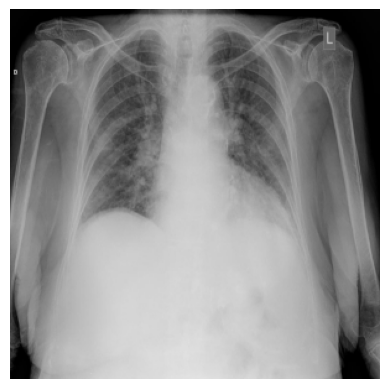

In [79]:
def load_image_from_url(url, target_size=(299, 299)):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)
    return img

image_url = 'https://miro.medium.com/v2/resize:fit:1024/1*xOUgrVK8Un03nd3brptPYg.png'
image = load_image_from_url(image_url)
plt.imshow(image)
plt.axis('off')
plt.show()

In [80]:
image = img_to_array(image)
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_ext_model = Model(inputs=base_model.inputs, outputs=x)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = feature_ext_model.predict(image, verbose=0)
feature

array([[0.03894509, 0.40166518, 0.36524886, ..., 0.00070769, 0.28978255,
        0.07562453]], dtype=float32)

In [81]:
caption_model = tf.keras.models.load_model('/kaggle/working/model.keras')

In [82]:
predict_caption(caption_model,feature,word_index,max_length)

'startseq chest x-ray showing bilateral interstitial infiltrates. in the left lung. endseq'